# Notes
* So far it seems like the methods we've employed (such as MDS and PCA) for predicting tissue locality work by reducing the dimension of the input data, which means that models using these methods have access to ~22,000 vectors of input data to start with. So the question I would like to pursue now is how to select the most useful (i.e. *predictive*) input vectors from the initial data set so you only work with those. 
    * A practical application of this to our work would be developing a simple quick test that predicts if someone has kidney cancer by only measuring the expressions of ~10 genes rather than the full ~20,000. 
    * This idea comes from Krishnan's *A flexible, interpretable, and accurate...* paper in which he states "the Library of Integrated Network-Baesd Cellular Signatures (LINCS)...has shown that measuring 978 'landmark' genes...costing only $5 per sample, is sufficient to then use to impute the expresssion of all other (tens of thousands of) genes." 
* **Three Methods**
    1. Univariate Selection: use sklearn's ```SelectKBest``` and ```f_classif()``` 
        * Used this link for univariate selection" [sklearn demo](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py)
    2. Recursive Feature Elimination
    3. Feature Importance (with bagged decision trees)

    * [helpful article](https://machinelearningmastery.com/feature-selection-machine-learning-python/) (we love Jason Brownlee)  
    
## Remaining Questions
* I wonder what the difference between MDS and PCA is...I sorta get it (PCA finds component vectors; MDS preserves sample-pair distances)

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import f_classif

plt.style.use('seaborn-darkgrid')
plt.rcParams['font.family']='serif'
plt.rcParams['mathtext.fontset']='stix'


In [54]:
feather_path = input('Enter path to local feather file: ')
tissue_df = pd.read_csv('https://raw.githubusercontent.com/HarritonResearchLab/genomics/main/exploring/first_topics/gene_prediction/tissue_prediction/data/tissue_df.csv')
tissues = np.array(tissue_df['tissue_ordinal'])
tissue_names = np.array(list(set(tissue_df['tissue_name'])))
feather_df = pd.read_feather(feather_path)

tissue_classes = {'cerebellum':0, 
                   'placenta':1,
                   'kidney':2, 
                   'endometrium':3,
                   'liver':4,
                   'colon':5,
                   'hippocampus':6}

### Univariate Selection

In [89]:
_, p_values = f_classif(X=feather_df, y=tissues)

scores = -np.log10(p_values)

scores /= np.max(scores)

sigma_mult = 5
cutoff_score = np.mean(scores)+sigma_mult*np.std(scores)

cutoff_mask = np.where(scores>np.mean(scores)+5*np.std(scores))[0]


[Text(0.5, 0, 'Feature Number'),
 Text(0, 0.5, 'Score $(-\\log_{10}\\mathrm{p})$'),
 Text(0.5, 1.0, 'Univariate Selection Scores')]

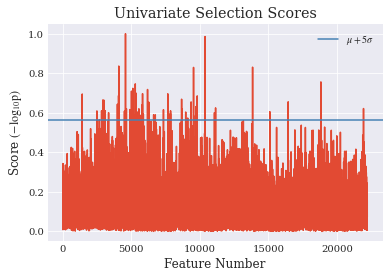

In [90]:
fig, ax = plt.subplots()

x = np.arange(0, len(scores), 1)

ax.plot(x, scores)

ax.axhline(cutoff_score, color='steelblue', label=r'$\mu+5\sigma$')

ax.legend()
ax.set(xlabel='Feature Number', 
       ylabel='Score '+r'$(-\log_{10}\mathrm{p})$', 
       title='Univariate Selection Scores')

In [106]:
masked_df = feather_df.iloc[:,cutoff_mask]
masked_df

,201884_at,202952_s_at,203130_s_at,203296_s_at,203399_x_at,203485_at,203540_at,203562_at,203807_x_at,204450_x_at,...,211657_at,211739_x_at,211741_x_at,211743_s_at,214465_at,215729_s_at,217073_x_at,219465_at,219466_s_at,39763_at
0,6.985233,5.489023,7.189865,5.230892,5.241265,5.998939,5.856596,7.121590,5.658283,6.933475,...,6.371476,5.748310,5.537732,6.431343,5.783487,6.168726,6.748861,5.181467,5.191942,8.518855
1,6.729160,5.657808,6.777313,5.475212,5.373265,5.527788,5.813841,7.498314,5.624447,6.845153,...,6.216659,5.604877,5.615538,6.165296,5.728870,4.815654,6.643951,5.103675,5.043176,8.577426
2,6.528775,5.354064,6.730205,5.323719,5.390883,5.254991,5.986338,6.930136,5.844455,7.293157,...,6.334296,5.923699,5.602002,6.240880,5.885257,4.770598,6.943869,5.310290,4.925632,8.890883
3,6.368677,5.327470,7.266023,5.342797,5.258098,5.068790,6.316815,6.851065,6.205448,7.232716,...,6.426836,6.069079,5.553959,6.433858,6.278272,4.902922,7.065750,5.466205,5.042079,9.069628
4,6.476114,5.209522,7.265034,5.275158,5.252868,5.789830,6.561705,6.810384,6.173464,7.214504,...,6.313114,6.161331,5.523730,6.331161,6.266166,4.826134,6.966310,5.459901,4.964297,8.839230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,6.761606,11.805339,6.662742,5.370166,11.549334,5.096592,6.304746,6.577589,14.191653,6.727406,...,6.833780,14.430288,12.086812,13.007373,5.742362,10.851123,6.479337,5.104431,5.387663,8.442343
185,6.663733,11.981240,6.289788,5.339120,12.231006,4.925843,6.261766,6.416475,13.336950,6.878290,...,6.662743,13.576662,12.725276,14.004967,5.752684,10.863143,6.771489,5.174848,5.385875,8.528493
186,6.381755,11.321692,5.681333,5.594216,11.217783,5.105377,5.690695,5.677650,12.775966,7.086965,...,6.467515,12.893884,11.366504,13.490284,5.876453,12.138991,6.761038,5.064882,5.205926,8.591092
187,7.091600,11.216799,5.881568,5.185668,10.232343,5.235319,6.176121,6.376013,12.449802,6.925653,...,6.281570,12.508900,9.695348,13.395421,5.548976,11.735247,7.136792,4.903623,5.476756,8.684174


In [109]:
ks = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
dims = [2, 4, 6, 8, 10]

models = []

for k in ks: 
    for dim in dims: 
        mds = MDS(random_state=3, n_components=dim)

        X_mds = mds.fit_transform(masked_df)
        
        new_df = pd.DataFrame(X_mds)

        X_train, X_test, y_train, y_test = train_test_split(new_df, tissues,test_size=0.15)

        knn = KNeighborsClassifier(k)
        knn.fit(X_train, y_train)
        predictions = knn.predict(X_test)

        acc = accuracy_score(predictions, y_test.flatten())

        models.append([k, dim, acc])
    
gs_results = pd.DataFrame(models, columns=['k', 'dim', 'acc'])
gs_results

,k,dim,acc
0,3,2,1.000000
1,3,4,0.965517
2,3,6,0.965517
3,3,8,1.000000
4,3,10,1.000000
5,5,2,1.000000
6,5,4,1.000000
7,5,6,0.931034
8,5,8,0.965517
9,5,10,1.000000


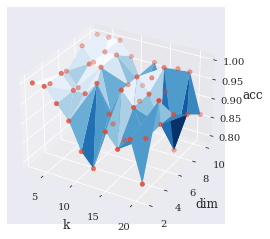

In [111]:
fig = plt.figure()

x = gs_results['k']
y = gs_results['dim']
z = gs_results['acc']

ax = plt.axes(projection='3d')
surface = ax.plot_trisurf(x, y, z, cmap='Blues_r')
ax.set_xlabel('k')
ax.set_ylabel('dim')
ax.set_zlabel('acc')

ax.scatter(x, y, z)

#mask = np.where(z==np.max(z))[0]

#ax.scatter(x[mask], y[mask], z[mask], color='red')

plt.show()

### Univariate Selection Sanity Check
* Take sixty lowest score values and see how well model works

### Recursive Feature Elimination

In [91]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

### Feature Importance

In [92]:
from sklearn.ensemble import ExtraTreesClassifier

In [104]:
model = ExtraTreesClassifier()
model.fit(feather_df, tissues)
etc_scores = model.feature_importances_

etc_scores *= 1/np.max(etc_scores)

(22215,)


No handles with labels found to put in legend.


[Text(0.5, 0, 'Feature Number'),
 Text(0, 0.5, 'Score'),
 Text(0.5, 1.0, 'ETC Selection')]

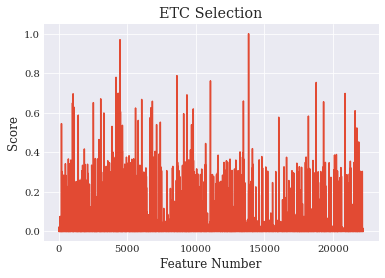

In [103]:
fig, ax = plt.subplots()

etc_x = np.arange(0, len(etc_scores), 1)

ax.plot(etc_x, etc_scores)

#ax.axhline(cutoff_score, color='steelblue', label=r'$\mu+5\sigma$')

ax.legend()
ax.set(xlabel='Feature Number', 
       ylabel='Score', 
       title='ETC Selection')

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt

x = np.linspace()